# Imports

In [1]:
import numpy as np
import pandas  as pd

In [2]:
# Text Preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
#SKLearn : Feature Engineering
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
# Visual
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# File system
import os
# Warning
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [49]:
train = pd.read_csv('CSV_file/train.csv')
print('Training Data Shape', train.shape)
train.head() # target is wrt disaster, then its 1

Training Data Shape (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [50]:
test = pd.read_csv('CSV_file/test.csv')
print('Testing Data Shape', test.shape)
test.head()

Testing Data Shape (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Exploratory Data Analysis (EDA)

## 1. Missing

In [8]:

train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

## 2. Target

In [31]:

train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:ylabel='target'>

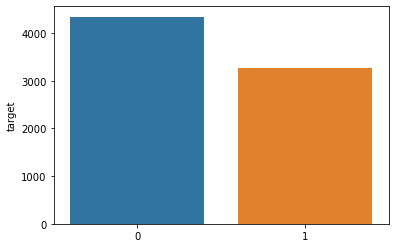

In [11]:
sns.barplot(train['target'].value_counts().index, train['target'].value_counts() )

In [12]:
disaster_tweet = train[train['target']==1]['text']
disaster_tweet.values[1]

'Forest fire near La Ronge Sask. Canada'

In [13]:
non_disaster_tweet = train[train['target']==0]['text']
non_disaster_tweet.values[1]

'I love fruits'

## 3. Keywords

<AxesSubplot:xlabel='keyword'>

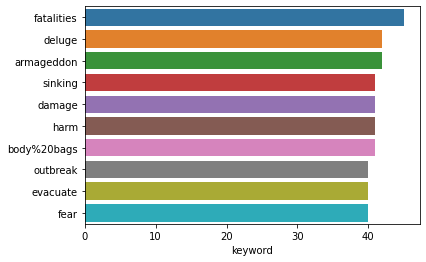

In [32]:

sns.barplot(y=train['keyword'].value_counts()[:10].index, x=train['keyword'].value_counts()[:10])

In [15]:
# Exact number of tweets with 'disaster' word
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

## 4. Location

<AxesSubplot:xlabel='location'>

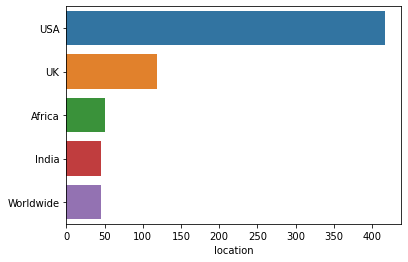

In [51]:

train['location'].replace({
                            'United States':'USA',
                            'New York':'USA',
                            'London':'UK',
                            'Los Angeles, CA':'USA',
                            'Washington, D.C':'USA',
                            'California':'USA',
                            'Chicago':'USA',
                            'Chicago, IL':'USA',
                            'New York': 'USA',
                            'California, USA':'USA',
                            'Florida':'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"
}, inplace=True)
sns.barplot(y=train['location'].value_counts()[:5].index, x=train['location'].value_counts()[:5])

# Text Data Preprocessing

## 1. Data Clean

In [17]:

train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [52]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))
train['text'][:5]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [53]:
disaster_tweet = train[train['target']==1]['text']
non_disaster_tweet = train[train['target']==0]['text']

Text(0.5, 1.0, 'Non-Disaster Tweets')

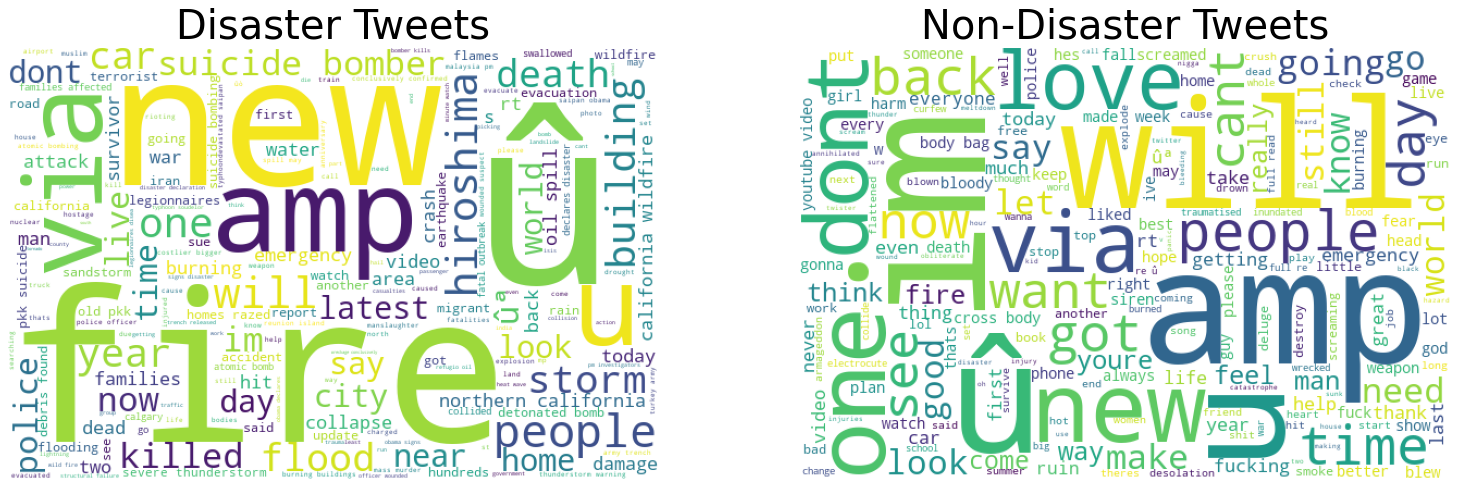

In [54]:
# show most occuring words for Disaster & Non-disaster tweets via WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

#Disaster tweets
wordcloud1 = WordCloud(
                        background_color='white',
                        width=600,
                        height=400
).generate(''.join(disaster_tweet))

ax1.imshow(wordcloud1) # image show: imshow
ax1.axis('off')
ax1.set_title('Disaster Tweets', fontsize=40)

#Non-Disaster tweets
wordcloud2 = WordCloud(
                        background_color='white',
                        width=600,
                        height=400
).generate(''.join(non_disaster_tweet))

ax2.imshow(wordcloud2) # image show: imshow
ax2.axis('off')
ax2.set_title('Non-Disaster Tweets', fontsize=40)

## 2. Token

In [55]:
# tokenizer not used for this disaster tweets, its only for instruction purpose
text = "Are you coming, aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

In [38]:
print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print()
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print()
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print()
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming, aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming,', "aren't", 'you']

Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']

Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']

Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [56]:
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [57]:
# Tokenising the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

## 3. Stopword

In [58]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    # return ''.join(words)
    return words

train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


### Combine text

In [60]:
# Combine the text to sentence
def combine_text(list_of_text):
    ''' Take a list of text and combine them into one large chunk of text'''
    combine_text = ' '.join(list_of_text)
    return combine_text

train['text'] = train['text'].apply(lambda x: combine_text(x))
test['text'] = test['text'].apply(lambda x: combine_text(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


## 4. Normalize

### Stemmer & Lammatize

In [59]:
text = 'feet cats wolves talked'
tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

#Stemmer
stemmer = nltk.stem.PorterStemmer()
print('Stemminf the Sent: ', ' '.join(stemmer.stem(token) for token in tokens))

#Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
print('Lemmatizing the Sent: ', ' '.join(lemmatizer.lemmatize(token) for token in tokens))

Stemminf the Sent:  feet cat wolv talk
Lemmatizing the Sent:  foot cat wolf talked


## Total Text-Pre_Processor

In [61]:
def text_preproc(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text